In [144]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [145]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

from custom_data_manager import AugmentationManager
from custom_data_manager import CustomDataCollector
from custom_data_manager import CustomDataLoader
from model_manager import ModelManager

In [139]:
IMG_SIZE=96

## Prepare

In [326]:
#Takes long time
custom_ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"

sub_dirs_to_load = ['0006', '0009', '0010', '0012', '0018', '0024', 
                    '0030', '0038','0050','0056','0059','0077','0081',
                    '0083','0086','0088','0011', '0037', '0054']

sub_dirs_to_load = ['0010', '0012', '0018', '0077', '0081']

train_types = ['0010', '0018', '0077']
val_types = ['0012','0081']


In [ ]:
data_collector = CustomDataCollector(IMG_SIZE, sub_dirs_to_load, custom_ycb_path)
data_collector.collect()
frames_poses_dict = data_collector.frames_poses_dict

In [166]:
aug_pipeline = [
        {"aug_type": "channel_shift", "parameters": []},
        {"aug_type": "rotation", "parameters": [50]},
        {"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [10, 0.2, True]},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [167]:
data_loader = CustomDataLoader(IMG_SIZE,augmentator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


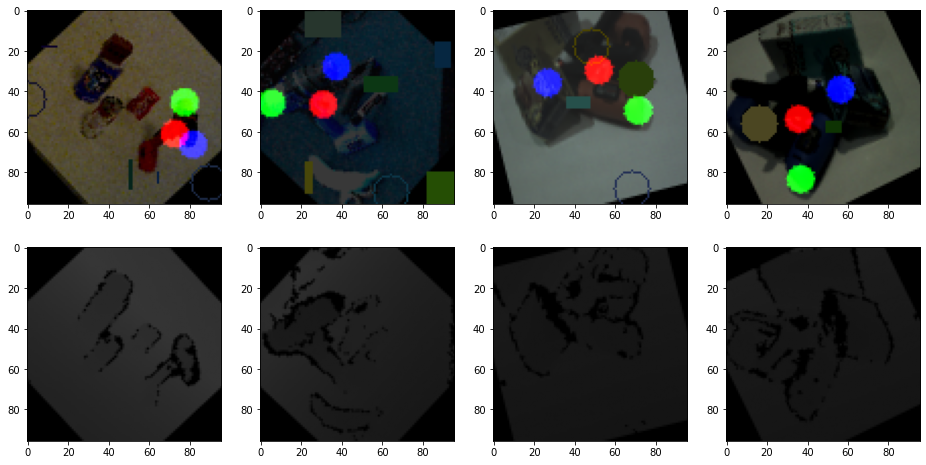

In [249]:
fig = plt.figure(figsize=(16, 8))
  
# setting values to rows and column variables
rows = 2
columns = 4

for i in range(4):
    dir_type = random.choice(sub_dirs_to_load)
    frame_number = int(random.random()*1000)
    img, mask, depth = data_loader.get_power_driver_trio(frames_poses_dict, dir_type, frame_number)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img/3+mask[:,:,0:3])
    fig.add_subplot(rows, columns, i+1+4)
    plt.imshow(depth)


## Generators

In [335]:
def power_driver_generator(data_loader, frames_poses_dict, dir_types_go_gen, frames_to_skip = 0, aug = False):
    while True:
        dir_type = random.choice(dir_types_go_gen)
        frames_number = len(frames_poses_dict[dir_type]['color_frames'])
        frame_number = int(random.random()*frames_number)
        color_frame, mask, depth = data_loader.get_power_driver_trio(frames_poses_dict, dir_type, frame_number, aug = aug)
        yield color_frame, mask

In [336]:
train_generator = power_driver_generator(data_loader, frames_poses_dict, train_types, aug = True)
val_generator = power_driver_generator(data_loader, frames_poses_dict, val_types, aug = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


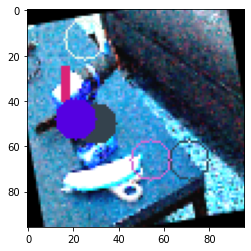

In [349]:
img, mask = next(train_generator)
plt.imshow(img)

In [308]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, gen, size):
        self.batch_size = batch_size
        self.on_epoch_end()
        self.gen = gen
        self.size = size
    def __len__(self):
        return int(self.size/self.batch_size)

    def __getitem__(self, index):
        #index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        #batch = [self.indices[k] for k in index]
        
        x_train = []
        y_train = []
        for i in range(self.batch_size):
            x, y = next(self.gen)
            x_train.append(x)
            y_train.append(y)
            
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        
        return x_train, y_train

    def on_epoch_end(self):
        pass


In [309]:
tf_train_generator = DataGenerator(batch_size=16, gen=train_generator, size = 22000/5)
tf_val_generator = DataGenerator(batch_size=16, gen=val_generator, size = 22000/5)

## Define Model

In [310]:
config = {}
model_manager = ModelManager(config)
model = model_manager.build_model(IMG_SIZE)

In [311]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 96, 96, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 96, 96, 16)  64          ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_34 (ReLU)                (None, 96, 96, 16)   0           ['batch_normalization_34[0]

                                                                                                  
 dropout_42 (Dropout)           (None, 6, 6, 256)    0           ['re_lu_42[0][0]']               
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 12, 12, 256)  590080     ['dropout_42[0][0]']             
 spose)                                                                                           
                                                                                                  
 batch_normalization_43 (BatchN  (None, 12, 12, 256)  1024       ['conv2d_transpose_8[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 re_lu_43 (ReLU)                (None, 12, 12, 256)  0           ['batch_normalization_43[0][0]'] 
          

 conv2d_40 (Conv2D)             (None, 96, 96, 16)   5056        ['concatenate_11[0][0]']         
                                                                                                  
 batch_normalization_50 (BatchN  (None, 96, 96, 16)  64          ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_50 (ReLU)                (None, 96, 96, 16)   0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 dropout_50 (Dropout)           (None, 96, 96, 16)   0           ['re_lu_50[0][0]']               
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 96, 7)    1015        ['dropout_50[0][0]']             
          

## Train

In [313]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss = "mse")

In [315]:
model.fit(tf_train_generator, 
            #validation_data = tf_val_generator,  
            epochs = 100, batch_size = 16,
           #callbacks=[my_callback()]
           )

Epoch 1/100
275/275 [==============================] - 23s 50ms/step - loss: 0.0186
Epoch 2/100
275/275 [==============================] - 14s 50ms/step - loss: 0.0138
Epoch 3/100
275/275 [==============================] - 14s 50ms/step - loss: 0.0132
Epoch 4/100
275/275 [==============================] - 14s 50ms/step - loss: 0.0124
Epoch 5/100
275/275 [==============================] - 14s 50ms/step - loss: 0.0114
Epoch 6/100
275/275 [==============================] - 14s 50ms/step - loss: 0.0104
Epoch 7/100
122/275 [============>.................] - ETA: 7s - loss: 0.0097

KeyboardInterrupt: 

## Evaulate